In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

#read data in 
df = pd.read_csv('phone_data_clean.csv')

In [2]:
#set capacity from 1-10
capacity = np.arange(1,11)
print(capacity)

[ 1  2  3  4  5  6  7  8  9 10]


In [3]:
def rho_f(lambda_hour,c,mew):
    rho = lambda_hour/(c*mew)
    return rho

def factorial(n):
    fact = 1
    if n==0:
        fact = 1
    else:
        for i in range(1,n+1):
            fact = fact * i
    return fact

def p_0_f(c,lambda_hour,mew,rho):
    #first_term = sum(((1/factorial(c-1))*((c*rho)**(c-1))) for c in range(1,c+1))
    #second_term = (1/factorial(c))*((rho*c)**c)*(1/(1-rho))
    first_term = sum(((1/factorial((c-1)))*((lambda_hour/mew)**(c-1))) for c in range(1,c+1))
    second_term = (1/factorial(c))*((lambda_hour/mew)**c)*((mew*c)/(mew*c - lambda_hour))
    p_0 = 1/(first_term + second_term)
    return p_0

def l_q_f(c,lambda_hour,mew,p_0,rho):
    #factor = (1/factorial(c))*((lambda_hour/mew)**c)*(rho/(1 - rho)**2)
    factor = (1/factorial(c-1))*((lambda_hour/mew)**c)*((mew*lambda_hour)/(c*mew - lambda_hour)**2)
    return factor*p_0

def l_s_f(l_q,lambda_hour,mew):
    return l_q + (lambda_hour/mew)

def l_w_f(c,mew,lambda_hour):
    return ((c*mew)/(c*mew - lambda_hour))

def w_q_f(l_q,lambda_hour):
    return l_q/lambda_hour

def w_s_f(l_s,lambda_hour):
    return l_s/lambda_hour


In [4]:
c = 3
mew = 0.5
lambda_hour = 1.2
rho = rho_f(lambda_hour, c, mew)
p_0  = p_0(c,lambda_hour,mew,rho)
l_q = l_q(c,lambda_hour,mew,p_0,rho)
w_q = w_q(l_q,lambda_hour)
print(rho,w_q)

NameError: name 'p_0' is not defined

In [5]:
df['Start time'] = pd.to_datetime(df['Start time'], format="%Y-%m-%d %H:%M:%S")
df['Duration'] = pd.to_timedelta(df['Duration'])
no_days = len(df['Start time'].dt.normalize().value_counts())
df = df.groupby(df['Call_ID'])

In [6]:
arrival_rate = {}
waiting_time = {}
service_time = {}
for i in range(7,21):
    arrival_rate[i] = 0
    waiting_time[i] = 0
    service_time[i] = 0

In [7]:
for name, group in df:
    #choose which hour the call falls into (chosen the time of answer)
    hour =(group['Start time'][group['Event type'] == "Answer ACD"]).dt.hour.values
    
    #ignores callls that have no answer
    if len(hour) == 0:
        continue
    else:
        hour = hour[0]
    
    #calculates arrival rates
    arrival_rate[hour] += (1/no_days)
    
for name, group in df:
    #choose which hour the call falls into (chosen the time of answer)
    hour =(group['Start time'][group['Event type'] == "Answer ACD"]).dt.hour.values
    
    #ignores callls that have no answer
    if len(hour) == 0:
        continue
    else:
        hour = hour[0]
    
    #calculates wating time, taken as ringing and time in queue
    wating_time_sum = 0
    queue = group['Duration'][group['Event type'] == "In Queue"]
    ringing = group['Duration'][group['Event type'] == "Ringing"]
    waiting_time_sum = sum(queue.values) + sum(ringing.values)
    waiting_time[hour] += (((waiting_time_sum.astype('timedelta64[ns]')) / np.timedelta64(1, 'h')))/(no_days*arrival_rate[hour])
    
    #calculates time on call, answer ACD
    service_time[hour] += (sum((group['Duration'][group['Event type'] == "Answer ACD"]).values).astype('timedelta64[ns]') / np.timedelta64(1, 'h'))/(no_days*arrival_rate[hour])

In [8]:
print(arrival_rate)
print(waiting_time)
print(service_time)

{7: 0, 8: 42.63636363636434, 9: 31.363636363636747, 10: 23.727272727272894, 11: 29.000000000000316, 12: 25.18181818181839, 13: 21.68181818181829, 14: 26.4545454545457, 15: 23.045454545454692, 16: 16.863636363636335, 17: 9.90909090909092, 18: 1.8636363636363626, 19: 0, 20: 0}
{7: 0, 8: 0.01839433783463601, 9: 0.012119967793880693, 10: 0.013268944231587828, 11: 0.011856495994426916, 12: 0.014976434015242542, 13: 0.023782320055904856, 14: 0.014224894998090737, 15: 0.01525147928994075, 16: 0.012923779574723012, 17: 0.012719164118246666, 18: 0.01086043360433605, 19: 0, 20: 0}
{7: 0, 8: 0.034392916370527646, 9: 0.03322866344605431, 10: 0.035985525755640346, 11: 0.03605407523510934, 12: 0.03461091054953844, 13: 0.03105637083624489, 14: 0.03254820542191647, 15: 0.03286598728906401, 16: 0.032237945492662526, 17: 0.031188837920489255, 18: 0.031802168021680226, 19: 0, 20: 0}


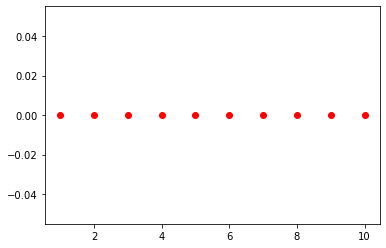

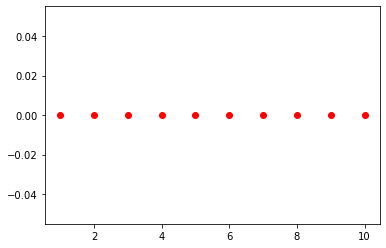

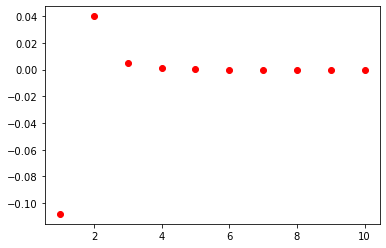

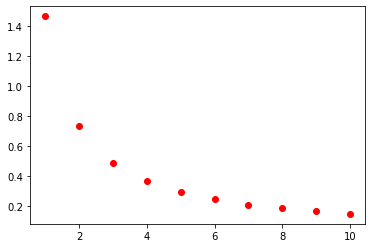

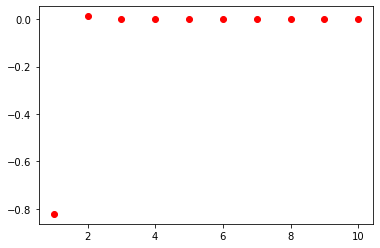

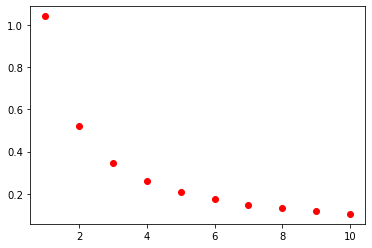

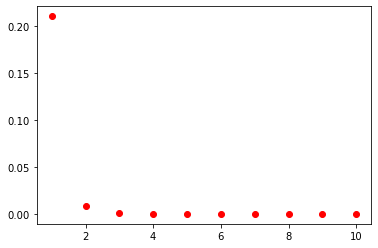

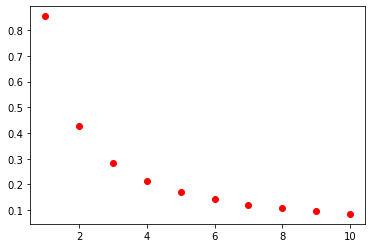

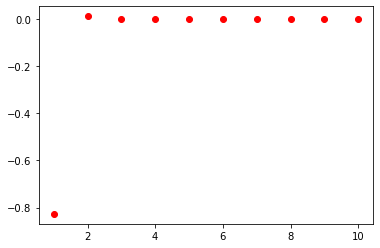

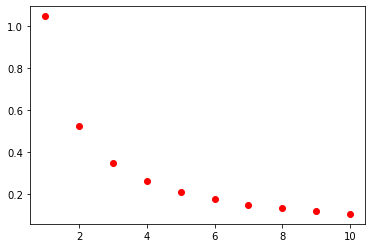

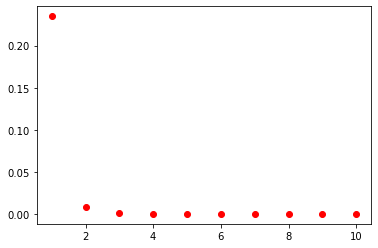

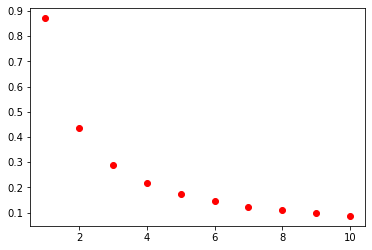

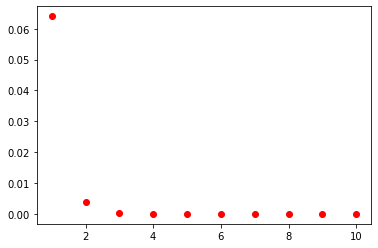

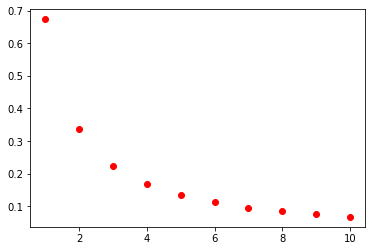

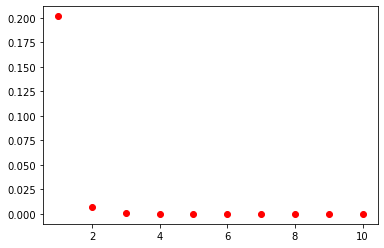

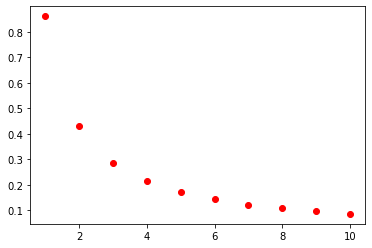

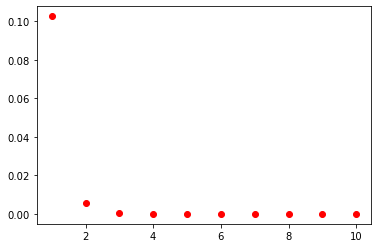

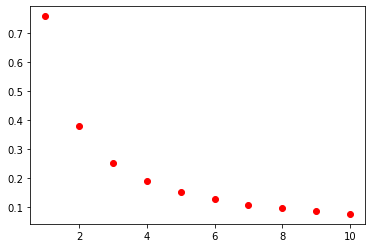

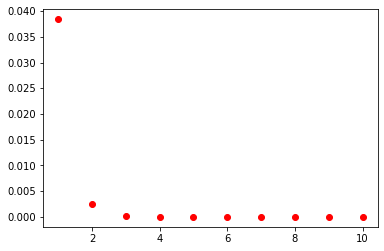

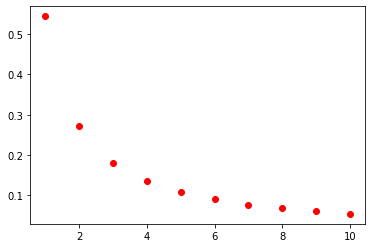

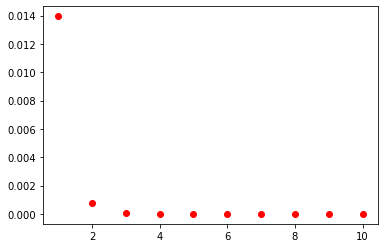

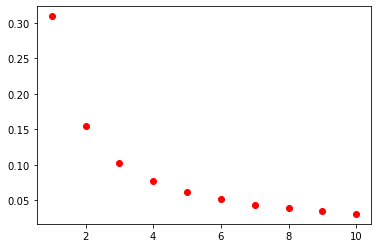

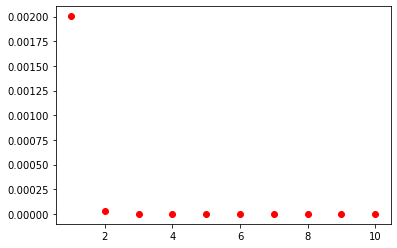

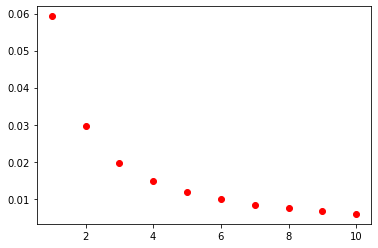

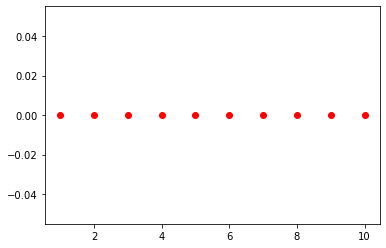

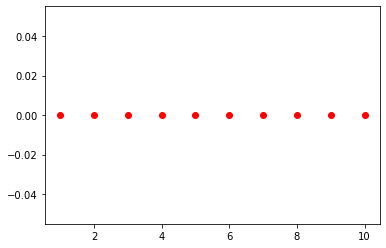

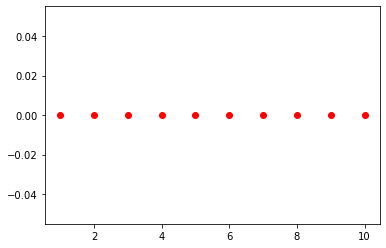

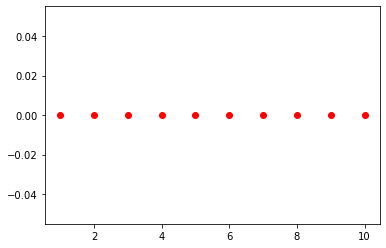

In [9]:
for hour in range(7,21):
    waiting_time = []
    rho_c = []
    for c in capacity:
        if service_time[hour] == 0 or arrival_rate[hour] == 0:
            rho = 0
            w_q = 0
        else:
            lambda_hour = arrival_rate[hour]
            mew = 1/service_time[hour]
            rho = rho_f(lambda_hour, c, mew)
            p_0  = p_0_f(c,lambda_hour,mew,rho)
            l_q = l_q_f(c,lambda_hour,mew,p_0,rho)
            w_q = w_q_f(l_q,lambda_hour)
        rho_c.append(rho)
        waiting_time.append(w_q)
    plt.figure()
    plt.plot(capacity, waiting_time, 'ro')
        
    # Show/save figure as desired.
    plt.show()
        
    plt.figure()
    plt.plot(capacity, rho_c, 'ro')